<a href="https://colab.research.google.com/github/ernestomancebo/DeepLearningInPractice/blob/main/transfer_learning/transfer_learning_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning - Fine Tunning

In this notebook we're **Fine Tunning** a Cat/Dog classifier using a pre-trained VGG16 model. Such model is a 5-block ConvNet and trained with more than a million of images of over 1K classes. That said, this base model can catch better representations/features than any model trained with few examples.

To *fine tune* this model, we're unfreezing the last convolutional block (**Layers 5**), training them back with really small steps (we don't wan to spoil the weights).

In [1]:
from google.colab import files
out = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!touch __ini__.py
!curl -O https://raw.githubusercontent.com/ernestomancebo/DeepLearningInPractice/main/transfer_learning/dataset_init.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2626  100  2626    0     0  10896      0 --:--:-- --:--:-- --:--:-- 10851


In [4]:
!kaggle competitions download -c dogs-vs-cats -p kaggle_original_data

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 34.8MB/s]
 98% 530M/543M [00:04<00:00, 142MB/s]
100% 543M/543M [00:04<00:00, 130MB/s]
 92% 249M/271M [00:04<00:00, 36.2MB/s]
100% 271M/271M [00:04<00:00, 68.6MB/s]


In [5]:
from dataset_init import set_up_cat_dogs_small_dataset

# this sets up our training dataset
directories =  set_up_cat_dogs_small_dataset()

#VGG16 - ImageNet

Now we load a pre-trained model, in specific the vgg16 pretrained with the ImageNet dataset

In [6]:
from keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

Now we create a new model on top of the `conv_base` since such model is a stack of layers.

In [7]:
from keras import models, layers

model = models.Sequential()
model.add(conv_base)
# Here we flat the output of the MaxPooling, so the Dense layers can consume it.
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


##Freezing `conv_base`
Here we freeze the convolutional base completely, so the weights are untouched and with this we remaing the hard work of the VGG16 creators :D

In [8]:
print('Number of trainable weights before freezing the conv_base: ', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights freezing the conv_base: ', len(model.trainable_weights))

Number of trainable weights before freezing the conv_base:  30
Number of trainable weights freezing the conv_base:  4


In this block we set the generators, so we can use them to train the new network.

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directories['train'],
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        directories['validation'],
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
%%capture

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)


Here's another helper, this time a plotting one.

In [11]:
!curl -O https://raw.githubusercontent.com/ernestomancebo/DeepLearningInPractice/main/transfer_learning/plot.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   830  100   830    0     0   4414      0 --:--:-- --:--:-- --:--:--  4414


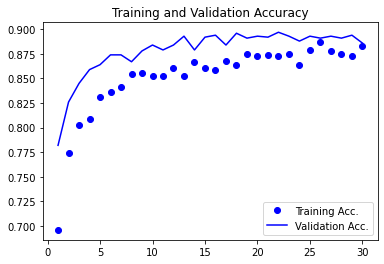

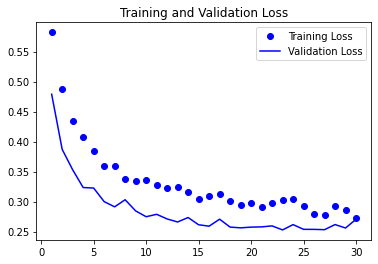

In [12]:
from plot import plot_trainig_results

plot_trainig_results(history)

HMM

###Freezing until the fifth block

Now we're freezing all the blocks but the fifht (**`block5_conv1`**), so we slightly adjust a bit the model by our dataset. This is kind of learning again for the `conv_base` by using new instances.

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [14]:
print('Number of trainable weights before unfreezing block5_conv1 and on: ', len(model.trainable_weights))

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True

  layer.trainable = set_trainable

print('Number of trainable weights after unfreezing block5_conv1: ', len(model.trainable_weights))

Number of trainable weights before unfreezing block5_conv1 and on:  4
Number of trainable weights after unfreezing block5_conv1:  10


In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [16]:
%%capture

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

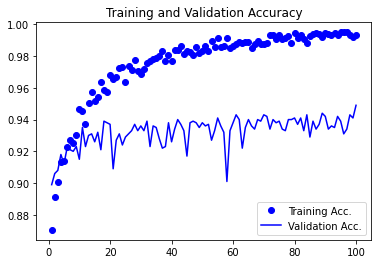

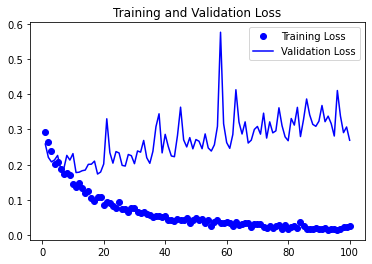

In [17]:
plot_trainig_results(history)

Let's smooth a bit the courves

In [23]:
epochs

100

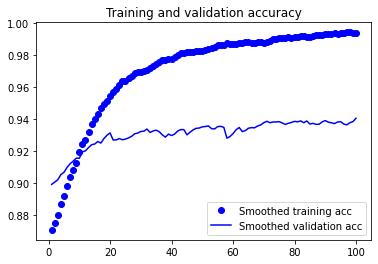

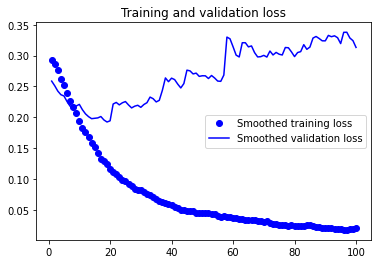

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)

  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###Test the Model
Finally we're testing the model using unseen data.

In [30]:
test_generator = test_datagen.flow_from_directory(
        directories['test'],
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9419999718666077


Not bad, a 0.94.